#### 1. Setup and Importing Libraries

In [39]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset # wraps an iterable around the dataset
from torchvision import datasets    # stores the samples and their corresponding labels
from torchvision.transforms import transforms  # transformations we can perform on our dataset
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import os
import wandb
import matplotlib.pyplot as plt

In [41]:
# Set API Key
os.environ["WANDB_API_KEY"] = "cf61e02cee13abdd3d8a232d29df527bd6cc7f89"

# Set the WANDB_NOTEBOOK_NAME environment variable to the name of your notebook (manually)
os.environ["WANDB_NOTEBOOK_NAME"] = "DataLoader.ipynb"

# set the WANDB_TEMP environment variable to a directory where we have write permissions
os.environ["WANDB_TEMP"] = os.getcwd()
os.environ["WANDB_DIR"] = os.getcwd()
os.environ["WANDB_CONFIG_DIR"] = os.getcwd()

In [42]:
wandb.init(project='ECG-analysis-with-Deep-Learning-on-GPU-accelerators')

wandb: Currently logged in as: e17338 (comprehensive-ecg-analysis). Use `wandb login --relogin` to force relogin


In [43]:
# Get cpu, gpu or mps device for training 
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090 Ti'

#### 2. Data Loader

In [3]:
class ECGDataSetPrevious(Dataset):
    
    def __init__(self):
        # data loading
        current_directory = os.getcwd()
        parent_directory = os.path.dirname(current_directory)
        train_small_path = os.path.join(parent_directory, 'data', 'deepfake-ecg-small', 'train.csv')
        xy = pd.read_csv(train_small_path)  # Skip the header row
        
        # QT
        self.y = torch.tensor(xy['qt'].values, dtype=torch.float32)
        patient_ids = xy['patid'].values

        # ECG reports
        self.x = []
        # read each asc file
        for patient_id in patient_ids:
            asc_path = os.path.join(parent_directory, 'data', 'deepfake-ecg-small', 'train', str(patient_id)+'.asc')
            ecg_data = np.loadtxt(asc_path)
            ecg_tensor = torch.from_numpy(ecg_data)
            ecg_tensor = ecg_tensor.float()
            ecg_tensor = ecg_tensor.permute(1, 0)#.unsqueeze(2)
            self.x.append(ecg_tensor)

        # Size of the dataset
        self.samples = xy.shape[0]

    def __getitem__(self, index):
        # Retrieve a sample from x and y based on the index
        return self.x[index], self.y[index]

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.samples
    
    # def read_file(self, filename):
    #     # Read the file and extract the lines
    #     with open(filename, 'r') as file:
    #         lines = file.readlines()
    #         # Initialize an empty matrix
    #         matrix = np.empty((8, 5000))
    #         # Iterate over each line and fill the matrix
    #         for i, line in enumerate(lines):
    #         # Split the line into individual values
    #             values = line.split()
    #             # Convert the values to integers and store them in the matrix
    #             matrix[:, i] = np.array(values, dtype=int)

    #     return matrix

In [7]:
class ECGDataSet(Dataset):
    
    def __init__(self):
        # data loading
        current_directory = os.getcwd()
        self.parent_directory = os.path.dirname(current_directory)
        train_small_path = os.path.join(self.parent_directory, 'data', 'deepfake-ecg-small', 'train.csv')
        self.df = pd.read_csv(train_small_path)  # Skip the header row
        
        # QT
        self.y = torch.tensor(self.df['qt'].values, dtype=torch.float32)

        # Size of the dataset
        self.samples = self.df.shape[0]

    def __getitem__(self, index):
        
        # file path
        filename= self.df['patid'].values[index]
        asc_path = os.path.join(self.parent_directory, 'data', 'deepfake-ecg-small', 'train', str(filename) + '.asc')
        
        ecg_signals = pd.read_csv( asc_path, header=None, sep=" ") # read into dataframe
        ecg_signals = torch.tensor(ecg_signals.values) # convert dataframe values to tensor
        
        ecg_signals = ecg_signals.float()
        
        # Transposing the ecg signals
        ecg_signals = ecg_signals/6000 # normalization
        ecg_signals = ecg_signals.t() 
        
        qt = self.y[index]
        # Retrieve a sample from x and y based on the index
        return ecg_signals, qt

    def __len__(self):
        # Return the total number of samples in the dataset
        return self.samples
    

In [8]:
# ECG dataset
dataset = ECGDataSet()

In [9]:
# first data
first_data = dataset[0]
x, y = first_data

In [10]:
x

tensor([[-0.0212, -0.0270, -0.0237,  ..., -0.0148, -0.0065, -0.0155],
        [-0.0002,  0.0000, -0.0077,  ..., -0.0030,  0.0037,  0.0008],
        [-0.0055, -0.0013, -0.0045,  ...,  0.0073,  0.0118,  0.0137],
        ...,
        [-0.0153, -0.0143, -0.0145,  ...,  0.0112,  0.0148,  0.0175],
        [-0.0102, -0.0112, -0.0117,  ...,  0.0087,  0.0147,  0.0043],
        [ 0.0003, -0.0048, -0.0042,  ...,  0.0115,  0.0213,  0.0192]])

In [11]:
y

tensor(434.)

In [12]:
x.shape

torch.Size([8, 5000])

In [13]:
y.shape

torch.Size([])

In [52]:
# data loader
# It allows you to efficiently load and iterate over batches of data during the training or evaluation process.
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=2)

### CNN

In [23]:
# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
batch_size = 32
dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

# # convert to an iterator and look at one random sample
# dataiter = iter(train_loader)
# data = next(dataiter)
# features, labels = data
# print(features, labels)

In [24]:
for x,y in dataloader:
    print(x.shape, y.shape)
    print(x.dtype, y.dtype)
    break

torch.Size([32, 8, 5000]) torch.Size([32])
torch.float32 torch.float32


In [25]:
# CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(8, 16, kernel_size=50, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 2500, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [26]:
# hyperparameters
num_classes = 1  # Number of output classes
learning_rate = 0.000000001
num_epochs = 10

In [27]:
model = CNN(num_classes)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [58]:
# Set up the wandb configuration and log hyperparameters
wandb.config.num_epochs = num_epochs
wandb.config.learning_rate = learning_rate

Epoch [1/10]
Epoch [2/10]
Epoch [3/10]
Epoch [4/10]
Epoch [5/10]
Epoch [6/10]
Epoch [7/10]
Epoch [8/10]
Epoch [9/10]
Epoch [10/10]


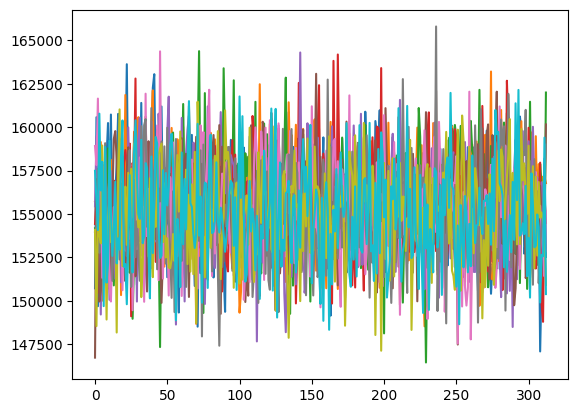

In [62]:
for epoch in range(wandb.config.num_epochs):
    losses = []  # List to store training losses
    for batch_inputs, batch_labels in dataloader:

        # Forward pass
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log training loss
        wandb.log({'loss': loss.item()})

        # Log epoch number
        wandb.log({'epoch': epoch})

         # Append loss to the list
        losses.append(loss.item())

    # Log other metrics and visualizations
    # Log training loss plot
    plt.plot(losses)
    wandb.log({"loss_plot": wandb.Image(plt)})


    # Print the loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [63]:
# Save the model
# torch.save(model.state_dict(), 'model.pt')

In [64]:
# finish
wandb.finish()

epoch,▁▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
loss,▆▁▅▂▂█▅▆▁▇▃▆▄▅▄▅▄█▄▇▄▂▄▆▁▆▄▆▄▃▇▃▃▅▃▄▁▅▄▃
epoch,9
loss,150392.01562


### Nueral Network

In [29]:
# Define the model
# nn.Module --> base class for all neural network modules
class NeuralNetwork(nn.Module):
    #network archirecture is defined in the init method
    def __init__(self):
        super().__init__()      #calls the __init__() method of the nn.Module pearent class 
        #( to ensure that the necessary setup and initialization from the parent class are performed.)
        #This is important because the nn.Module class performs important bookkeeping tasks and sets up the internal state of the module.

        #self.x are methods below. 
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential( # allows to stack multiple layers in a sequential manner
            nn.Linear(8*5000,1000 ),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500,1)
        )
        

    # method to define the forward pass computation of the model
    def forward(self, x):
        #x = self.flatten(x)   --> __call__ method is used to call the forward method (IMPORTANT)
        #x = self.linear_relu_stack(x) this also can be used
        x = self.flatten.forward(x)
        logits = self.linear_relu_stack.forward(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=1, bias=True)
  )
)


In [30]:
# loss function
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [31]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # get the total number of samples in the dataset
    model.train()   #sets the model in training mode (Stets the attribute named Training to True for the model instance) 
    #Dropout, batch normalization, etc. are used during training.

    # iterates over the batches in the dataloader
    for batch, (X, y) in enumerate(dataloader):
        # moves the input data to the device
        X, y = X.to(device), y.to(device)

        # compute prediction and loss --> Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward() # compute the gradients of the model's parameters with respect to the loss function's output
        optimizer.step()    #Update the models parameters an optimization algorithm
        optimizer.zero_grad()   # Sets all the gradients to zero. If the gradients are not cleared they ll be accumilated.

        # prints the progress of the training
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [32]:
%%time
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
    #test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 153863.000000  [    0/10000]
loss: 46131.101562  [ 3200/10000]
loss: 23244.507812  [ 6400/10000]
loss: 20522.169922  [ 9600/10000]
Epoch 2
-------------------------------


/storage/projects2/e17-4yp-compreh-ecg-analysis/minicondaInst/envs/test/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 14137.524414  [    0/10000]
loss: 15390.925781  [ 3200/10000]
loss: 11066.703125  [ 6400/10000]
loss: 10521.293945  [ 9600/10000]
Epoch 3
-------------------------------
loss: 4095.266846  [    0/10000]
loss: 7654.701172  [ 3200/10000]
loss: 4049.261719  [ 6400/10000]
loss: 4833.816406  [ 9600/10000]
Epoch 4
-------------------------------
loss: 2947.991699  [    0/10000]
loss: 4345.424805  [ 3200/10000]
loss: 3229.486572  [ 6400/10000]
loss: 3201.381104  [ 9600/10000]
Epoch 5
-------------------------------
loss: 2689.642578  [    0/10000]
loss: 2575.834229  [ 3200/10000]
loss: 2501.104004  [ 6400/10000]
loss: 3230.678223  [ 9600/10000]
Epoch 6
-------------------------------
loss: 1279.877808  [    0/10000]
loss: 1154.874146  [ 3200/10000]
loss: 1721.617188  [ 6400/10000]
loss: 1112.253662  [ 9600/10000]
Epoch 7
-------------------------------
loss: 1334.359619  [    0/10000]
loss: 1451.772705  [ 3200/10000]
loss: 1268.673584  [ 6400/10000]
loss: 1245.611450  [ 9600/10000]
Epoc